In [ ]:
from datetime import datetime
import requests
from io import StringIO
import json
import pandas as pd
import geopandas as gpd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import folium
from shapely.geometry import Point


# Analyzing Aggravated Burglaries in Davidson County

1. A dataset containing details about Metro Nashville Police Department reported incidents is available at https://data.nashville.gov/Police/Metro-Nashville-Police-Department-Incidents/2u6v-ujjs. Make use of the API to find all aggravated burglary incidents that were reported during the six month period from January 1, 2021 through June 30, 2021.


In [ ]:
census_tracts = gpd.read_file('../data/tl_2019_47_tract.shp')

In [ ]:
# show maximum number of columns
pd.options.display.max_columns = 500
# request json form API,set parameters, response
import requests
endpoint = 'https://data.nashville.gov/resource/2u6v-ujjs.json'
params = {'offense_description' : 'BURGLARY- AGGRAVATED', '$where': "incident_reported between '2021-01-01' and '2021-06-30'", '$limit': 50000}
response = requests.get(endpoint, params)


In [ ]:
#read json
from io import StringIO
burglaries = pd.read_json(StringIO(response.text))
burglaries.head(2)
type(burglaries)

pandas.core.frame.DataFrame

In [ ]:
#turn burglaries into a geo df and match its crs to census_tracts df
burglaries['geometry'] = burglaries.apply(lambda x: Point((x['longitude'], 
                                                         x['latitude'])), 
                                        axis=1) # columns
burglaries = gpd.GeoDataFrame(burglaries, crs = census_tracts.crs, geometry = burglaries['geometry'])
type(burglaries)

geopandas.geodataframe.GeoDataFrame

In [ ]:
# look into the DF
print(burglaries.info())
print(burglaries.columns)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1046 entries, 0 to 1045
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   primary_key                  1046 non-null   int64   
 1   incident_number              1046 non-null   int64   
 2   report_type                  1046 non-null   object  
 3   report_type_description      1034 non-null   object  
 4   incident_status_code         1046 non-null   object  
 5   incident_status_description  1046 non-null   object  
 6   investigation_status         1046 non-null   object  
 7   incident_occurred            1046 non-null   object  
 8   incident_reported            1046 non-null   object  
 9   incident_location            1044 non-null   object  
 10  latitude                     1044 non-null   float64 
 11  longitude                    1044 non-null   float64 
 12  rpa                          964 non-null    float64 


In [ ]:
# delete null values from the longitude/latitude columns(to be matched later andnulls might make problems)
burglaries = burglaries.dropna(subset = ['latitude', 'longitude']).drop_duplicates('incident_number') 


2. Download the 2019 census tract shapefiles for Tennessee from https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2019.html. (The FIPS code for Tennessee is 47). Perform a spatial join to determine the census tract in which each burglary incident occurred. Which census tract had the highest number of burglaries? Warning - each incident can appear multiple times if there are multiple victims, so be sure that you aren't double-counting any incidents.


In [ ]:

# limit the data to the Davidson county and clean columns
census_tracts = census_tracts[census_tracts['COUNTYFP'] == '037']
census_tracts.head(2)

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
27,47,037,010106,47037010106,101.06,Census Tract 101.06,G5020,S,21505677,6845,+36.2610013,-086.8023491,"POLYGON ((-86.83089 36.26570, -86.83016 36.265..."
36,47,037,010103,47037010103,101.03,Census Tract 101.03,G5020,S,48020418,61097,+36.3444054,-086.8608396,"POLYGON ((-86.91752 36.33976, -86.91747 36.339..."


In [ ]:
burglaries = gpd.sjoin(burglaries, census_tracts, op = 'within')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3361: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [ ]:
type(burglaries)

geopandas.geodataframe.GeoDataFrame

In [ ]:
#find the tract with the most burglaries
burglaries.groupby('TRACTCE')['incident_number'].nunique().nlargest(5)

TRACTCE
016300    53
016200    21
011001    20
019300    19
019500    19
Name: incident_number, dtype: int64

3. For this part, you'll need to request a [census API key](https://api.census.gov/data/key_signup.html). Using the [2019 American Community Survey API](https://www.census.gov/data/developers/data-sets/acs-5year.html), obtain, for each census tract, the population (B01001_001E in the detailed tables) and the median income (S1901_C01_012E in the subject tables). Hint: Tennessee's FIPS code is 47 and Davidson County's FIPS code is 37. Merge this new data with the burglaries data above.


In [ ]:
#get the second DF from the Census API
endpoint = 'https://api.census.gov/data/2019/acs/acs5'

# get from population, get every tract *, limit to TN davidson
parameters = {'get': 'NAME,B01001_001E', 'for': 'tract:*', 'in' : 'state:47 county:037' }  
response = requests.get(endpoint, params= parameters )
davidson_pop = pd.read_json(StringIO(response.text))
davidson_pop



,0,1,2,3,4
0,NAME,B01001_001E,state,county,tract
1,"Census Tract 156.31, Davidson County, Tennessee",12176,47,037,015631
2,"Census Tract 158.04, Davidson County, Tennessee",4098,47,037,015804
3,"Census Tract 177.01, Davidson County, Tennessee",2466,47,037,017701
4,"Census Tract 177.02, Davidson County, Tennessee",5210,47,037,017702
...,...,...,...,...,...
157,"Census Tract 156.13, Davidson County, Tennessee",5252,47,037,015613
158,"Census Tract 156.20, Davidson County, Tennessee",7262,47,037,015620
159,"Census Tract 161, Davidson County, Tennessee",2345,47,037,016100
160,"Census Tract 114, Davidson County, Tennessee",4617,47,037,011400


In [ ]:
#Print info about DF2
print(davidson_pop.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       162 non-null    object
 1   1       162 non-null    object
 2   2       162 non-null    object
 3   3       162 non-null    object
 4   4       162 non-null    object
dtypes: object(5)
memory usage: 6.5+ KB
None


In [ ]:
# slice the calue of first row, the get rid of the first row
davidson_pop.columns = davidson_pop.iloc[0] # loc will do the same here
davidson_pop = davidson_pop[1:]
davidson_pop

,NAME,B01001_001E,state,county,tract
1,"Census Tract 156.31, Davidson County, Tennessee",12176,47,037,015631
2,"Census Tract 158.04, Davidson County, Tennessee",4098,47,037,015804
3,"Census Tract 177.01, Davidson County, Tennessee",2466,47,037,017701
4,"Census Tract 177.02, Davidson County, Tennessee",5210,47,037,017702
5,"Census Tract 183.01, Davidson County, Tennessee",8254,47,037,018301
...,...,...,...,...,...
157,"Census Tract 156.13, Davidson County, Tennessee",5252,47,037,015613
158,"Census Tract 156.20, Davidson County, Tennessee",7262,47,037,015620
159,"Census Tract 161, Davidson County, Tennessee",2345,47,037,016100
160,"Census Tract 114, Davidson County, Tennessee",4617,47,037,011400


In [ ]:
#change the column name to population
davidson_pop = davidson_pop.rename(columns = {'B01001_001E':'population'})
davidson_pop.head(2)

,NAME,population,state,county,tract
1,"Census Tract 156.31, Davidson County, Tennessee",12176,47,037,015631
2,"Census Tract 158.04, Davidson County, Tennessee",4098,47,037,015804


In [ ]:
#turn the population column data type to int
davidson_pop['population'] = davidson_pop['population'].astype('int')

In [767]:
# do the same for the income data
endpoint = 'https://api.census.gov/data/2018/acs/acs5/subject'
parameters = {
    'get': 'NAME,S1901_C01_012E', 
    'for': 'tract:*',
    'in' : 'state:47 county:037' 
} 
response = requests.get(endpoint, params= parameters )
davidson_inc = pd.read_json(StringIO(response.text))
davidson_inc.columns = davidson_inc.iloc[0]
davidson_inc = davidson_inc[1:]
davidson_inc

,NAME,S1901_C01_012E,state,county,tract
1,"Census Tract 133, Davidson County, Tennessee",51863,47,037,013300
2,"Census Tract 172, Davidson County, Tennessee",41463,47,037,017200
3,"Census Tract 184.08, Davidson County, Tennessee",115116,47,037,018408
4,"Census Tract 114, Davidson County, Tennessee",44492,47,037,011400
5,"Census Tract 138, Davidson County, Tennessee",33118,47,037,013800
...,...,...,...,...,...
157,"Census Tract 109.03, Davidson County, Tennessee",35976,47,037,010903
158,"Census Tract 139, Davidson County, Tennessee",25521,47,037,013900
159,"Census Tract 189.01, Davidson County, Tennessee",53750,47,037,018901
160,"Census Tract 178, Davidson County, Tennessee",76014,47,037,017800


In [768]:
davidson_inc = davidson_inc.rename(columns = {'S1901_C01_012E':'income'})
davidson_inc['income'] = davidson_inc['income'].astype('int')
davidson_inc.head(2)

,NAME,income,state,county,tract
1,"Census Tract 133, Davidson County, Tennessee",51863,47,037,013300
2,"Census Tract 172, Davidson County, Tennessee",41463,47,037,017200


In [769]:
#merge census_pop and census_inc
census_data = pd.merge(davidson_pop, davidson_inc)
census_data.head(2)

,NAME,population,state,county,tract,income
0,"Census Tract 156.31, Davidson County, Tennessee",12176,47,037,015631,75158
1,"Census Tract 158.04, Davidson County, Tennessee",4098,47,037,015804,44357


In [770]:

census_data.rename(columns = {'tract': 'TRACTCE'})

,NAME,population,state,county,TRACTCE,income
0,"Census Tract 156.31, Davidson County, Tennessee",12176,47,037,015631,75158
1,"Census Tract 158.04, Davidson County, Tennessee",4098,47,037,015804,44357
2,"Census Tract 177.01, Davidson County, Tennessee",2466,47,037,017701,131065
3,"Census Tract 177.02, Davidson County, Tennessee",5210,47,037,017702,99821
4,"Census Tract 183.01, Davidson County, Tennessee",8254,47,037,018301,70929
...,...,...,...,...,...,...
156,"Census Tract 156.13, Davidson County, Tennessee",5252,47,037,015613,37467
157,"Census Tract 156.20, Davidson County, Tennessee",7262,47,037,015620,44558
158,"Census Tract 161, Davidson County, Tennessee",2345,47,037,016100,36568
159,"Census Tract 114, Davidson County, Tennessee",4617,47,037,011400,44492


In [771]:
burglaries.columns

Index(['primary_key', 'incident_number', 'report_type',
       'report_type_description', 'incident_status_code',
       'incident_status_description', 'investigation_status',
       'incident_occurred', 'incident_reported', 'incident_location',
       'latitude', 'longitude', 'rpa', 'zone', 'location_code',
       'location_description', 'offense_number', 'offense_nibrs',
       'offense_description', 'weapon_primary', 'weapon_description',
       'victim_number', 'domestic_related', 'victim_type',
       'victim_description', 'victim_gender', 'victim_race',
       'victim_ethnicity', 'victim_county_resident', 'mapped_location',
       'zip_code', 'geometry', 'index_right', 'STATEFP', 'COUNTYFP', 'TRACTCE',
       'GEOID', 'NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER',
       'INTPTLAT', 'INTPTLON'],
      dtype='object')

Create a choropleth showing the number of burglaries per 1000 residents for each census tract.

In [772]:
census_data.columns

Index(['NAME', 'population', 'state', 'county', 'tract', 'income'], dtype='object', name=0)

In [773]:
#change the name of the columns before the merge
census_data = census_data.rename(columns = {'tract': 'TRACTCE'})

In [774]:
#do sjoin on burglaries and census_data
burg_census = pd.merge(burglaries, census_data, on = 'TRACTCE')
burg_census

,primary_key,incident_number,report_type,report_type_description,incident_status_code,incident_status_description,investigation_status,incident_occurred,incident_reported,incident_location,latitude,longitude,rpa,zone,location_code,location_description,offense_number,offense_nibrs,offense_description,weapon_primary,weapon_description,victim_number,domestic_related,victim_type,victim_description,victim_gender,victim_race,victim_ethnicity,victim_county_resident,mapped_location,zip_code,geometry,index_right,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME_x,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,NAME_y,population,state,county,income
0,2021024954011,20210249540,D,DISPATCHED,O,OPEN,Open,2021-05-04T23:45:00.000,2021-05-05T00:45:00.000,UNIVERSITY CT,36.150,-86.770,8203.0,511.0,22,"RESIDENCE, HOME",1,220,BURGLARY- AGGRAVATED,09,PERSONAL (HANDS),1,False,I,INDIVIDUAL (18 AND OVER),F,B,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.77, 36.15]}",NaN,POINT (-86.77000 36.15000),652,47,037,016000,47037016000,160,Census Tract 160,G5020,S,1158914,0,+36.1454955,-086.7638143,"Census Tract 160, Davidson County, Tennessee",945,47,037,40430
1,2021018707011,20210187070,D,DISPATCHED,O,OPEN,Open,2021-04-02T09:30:00.000,2021-04-02T20:04:00.000,LITTLE HAMILTON AVE,36.140,-86.760,8009.0,815.0,22,"RESIDENCE, HOME",1,220,BURGLARY- AGGRAVATED,09,PERSONAL (HANDS),1,False,I,INDIVIDUAL (18 AND OVER),F,W,Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.76, 36.14]}",NaN,POINT (-86.76000 36.14000),652,47,037,016000,47037016000,160,Census Tract 160,G5020,S,1158914,0,+36.1454955,-086.7638143,"Census Tract 160, Davidson County, Tennessee",945,47,037,40430
2,2021000686911,20210006869,D,DISPATCHED,O,OPEN,Open,2021-01-04T10:45:00.000,2021-01-05T03:11:00.000,RAINS AVE,36.140,-86.760,8011.0,817.0,90,APARTMENT,1,220,BURGLARY- AGGRAVATED,17,NONE,1,False,I,INDIVIDUAL (18 AND OVER),F,A,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.76, 36.14]}",NaN,POINT (-86.76000 36.14000),652,47,037,016000,47037016000,160,Census Tract 160,G5020,S,1158914,0,+36.1454955,-086.7638143,"Census Tract 160, Davidson County, Tennessee",945,47,037,40430
3,2021022322011,20210223220,D,DISPATCHED,O,OPEN,Open,2021-04-20T20:00:00.000,2021-04-21T10:00:00.000,2ND AVE S,36.150,-86.770,8153.0,311.0,22,"RESIDENCE, HOME",1,220,BURGLARY- AGGRAVATED,17,NONE,1,False,I,INDIVIDUAL (18 AND OVER),F,W,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.77, 36.15]}",NaN,POINT (-86.77000 36.15000),652,47,037,016000,47037016000,160,Census Tract 160,G5020,S,1158914,0,+36.1454955,-086.7638143,"Census Tract 160, Davidson County, Tennessee",945,47,037,40430
4,2021001370911,20210013709,D,DISPATCHED,O,OPEN,Open,2021-01-07T21:45:00.000,2021-01-08T02:35:00.000,LEWIS ST,36.140,-86.760,8137.0,311.0,90,APARTMENT,1,220,BURGLARY- AGGRAVATED,16,Unarmed,1,False,I,INDIVIDUAL (18 AND OVER),M,B,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.76, 36.14]}",NaN,POINT (-86.76000 36.14000),652,47,037,016000,47037016000,160,Census Tract 160,G5020,S,1158914,0,+36.1454955,-086.7638143,"Census Tract 160, Davidson County, Tennessee",945,47,037,40430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817,2021031697111,20210316971,D,DISPATCHED,A,CLEARED BY ARREST,Closed,2021-06-08T19:00:00.000,2021-06-09T19:35:00.000,2903 2903,36.082,-86.603,8997.0,335.0,22,"RESIDENCE, HOME",1,220,BURGLARY- AGGRAVATED,17,NONE,1,False,I,INDIVIDUAL (18 AND OVER),F,W,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.603, 36....",37013.0,POINT (-86.60300 36.08200),565,47,037,015619,47037015619,156.19,Census Tract 156.19,G5020,S,7162263,8705939,+36.0872112,-086.5882734,"Census Tract 156.19, Davidson County, Tennessee",5105,47,037,70000
818,2021034466611,20210344666,D,DISPATCHED,R,REFUSED TO COOPERATE,Closed,2021-06-24T14:00:00.000,2021-06-24T14:31:00.

4. Creaate choropleth showing the number of burglaries per 1000 residents for each census tract.

In [775]:
# To look at burglaries per tract, group by tract. Since we want count, it does not matter what columns to aggregate on
#this gives us a series, se we turn it into a DF
burg_per_tract = burg_census.groupby('TRACTCE')['incident_number'].nunique().reset_index()
burg_per_tract



,TRACTCE,incident_number
0,010104,5
1,010105,3
2,010106,7
3,010201,4
4,010301,1
...,...,...
142,019300,19
143,019400,9
144,019500,19
145,019600,5


In [776]:
#when we do the groupby, it wrongly keeps the column name: rename it
burg_per_tract.rename(columns = {'incident_number' : 'burg_count_per_tract'})

,TRACTCE,burg_count_per_tract
0,010104,5
1,010105,3
2,010106,7
3,010201,4
4,010301,1
...,...,...
142,019300,19
143,019400,9
144,019500,19
145,019600,5


In [780]:
#merge the new df into the main df
burg_census.merge(burg_per_tract)

,primary_key,incident_number,report_type,report_type_description,incident_status_code,incident_status_description,investigation_status,incident_occurred,incident_reported,incident_location,latitude,longitude,rpa,zone,location_code,location_description,offense_number,offense_nibrs,offense_description,weapon_primary,weapon_description,victim_number,domestic_related,victim_type,victim_description,victim_gender,victim_race,victim_ethnicity,victim_county_resident,mapped_location,zip_code,geometry,index_right,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME_x,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,NAME_y,population,state,county,income
0,2021024954011,20210249540,D,DISPATCHED,O,OPEN,Open,2021-05-04T23:45:00.000,2021-05-05T00:45:00.000,UNIVERSITY CT,36.15,-86.77,8203.0,511.0,22,"RESIDENCE, HOME",1,220,BURGLARY- AGGRAVATED,09,PERSONAL (HANDS),1,False,I,INDIVIDUAL (18 AND OVER),F,B,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.77, 36.15]}",NaN,POINT (-86.77000 36.15000),652,47,037,016000,47037016000,160,Census Tract 160,G5020,S,1158914,0,+36.1454955,-086.7638143,"Census Tract 160, Davidson County, Tennessee",945,47,037,40430
1,2021018707011,20210187070,D,DISPATCHED,O,OPEN,Open,2021-04-02T09:30:00.000,2021-04-02T20:04:00.000,LITTLE HAMILTON AVE,36.14,-86.76,8009.0,815.0,22,"RESIDENCE, HOME",1,220,BURGLARY- AGGRAVATED,09,PERSONAL (HANDS),1,False,I,INDIVIDUAL (18 AND OVER),F,W,Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.76, 36.14]}",NaN,POINT (-86.76000 36.14000),652,47,037,016000,47037016000,160,Census Tract 160,G5020,S,1158914,0,+36.1454955,-086.7638143,"Census Tract 160, Davidson County, Tennessee",945,47,037,40430


In [782]:
burg_census.columns

Index(['primary_key', 'incident_number', 'report_type',
       'report_type_description', 'incident_status_code',
       'incident_status_description', 'investigation_status',
       'incident_occurred', 'incident_reported', 'incident_location',
       'latitude', 'longitude', 'rpa', 'zone', 'location_code',
       'location_description', 'offense_number', 'offense_nibrs',
       'offense_description', 'weapon_primary', 'weapon_description',
       'victim_number', 'domestic_related', 'victim_type',
       'victim_description', 'victim_gender', 'victim_race',
       'victim_ethnicity', 'victim_county_resident', 'mapped_location',
       'zip_code', 'geometry', 'index_right', 'STATEFP', 'COUNTYFP', 'TRACTCE',
       'GEOID', 'NAME_x', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER',
       'INTPTLAT', 'INTPTLON', 'NAME_y', 'population', 'state', 'county',
       'income'],
      dtype='object')

In [778]:
burg_per_1000 = burg_census['']

KeyError: ''

<AxesSubplot:>

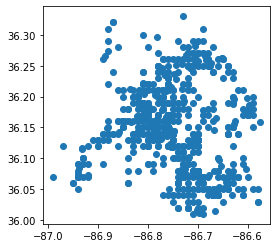

In [ ]:
burg_census.plot()